<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/coopLearningOutcomesProject/SPX_500_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Anomaly Detection Notebook 
### TODO 
and nasdaq (QQQ).. test iso forest for him dimm dataset(s) 

then create a stack of finance related stock and rerun.... fry my cpu :'( 

list of sources 
* https://github.com/edyoda/data-science-complete-tutorial/blob/master/13.%20Anomaly%20Detection.ipynb



In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#!pip install yfinance
import yfinance as yf # https://github.com/ranaroussi/yfinance


from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [342]:
SPY = yf.Ticker("spy")
SPY = SPY.history(period='20y')
SPY_open = pd.DataFrame({'close':SPY["Close"]})
SPY_open.head(10)

,close
Date,
1999-10-28,92.73
1999-10-29,94.41
1999-11-01,93.42
1999-11-02,92.75
1999-11-03,93.38
1999-11-04,94.09
1999-11-05,95.01
1999-11-08,95.10
1999-11-09,94.21


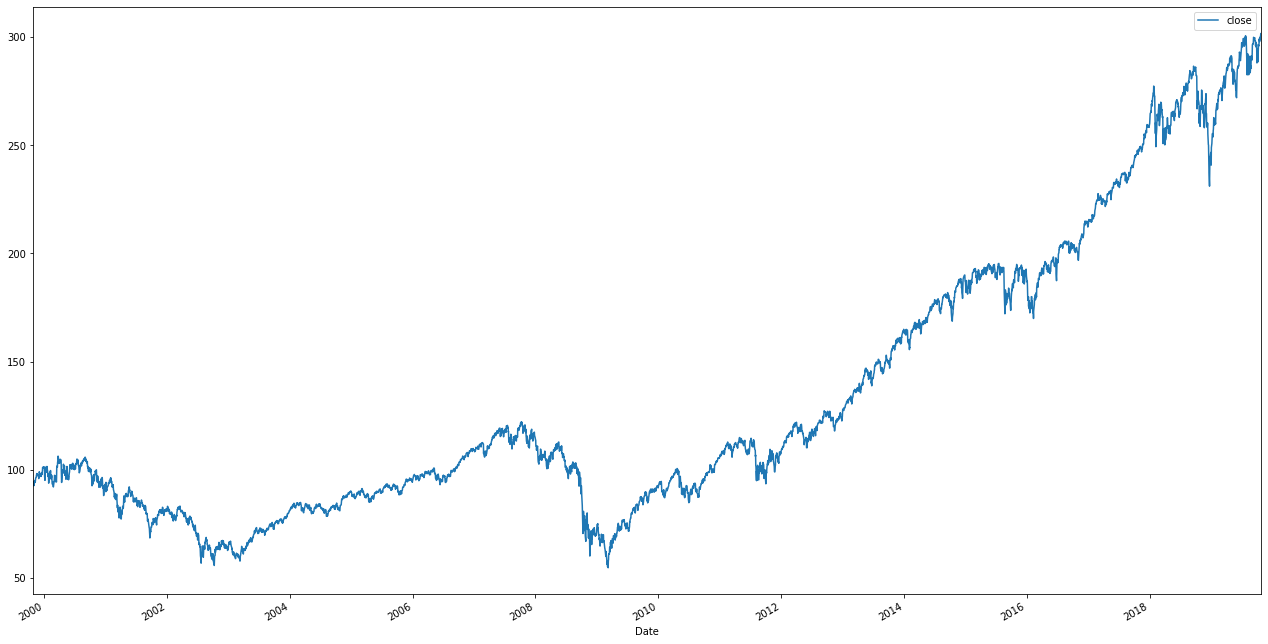

In [343]:
spy = SPY_open
spy.plot(figsize=(22,12), use_index=True)

In [0]:
x= spy.close.values # ndarray 
X = x.reshape(-1,1)

## K-Means Shit 

ya.. thats a pun on this shitty useless method  

In [345]:
km = KMeans(80).fit(X)
# plt.figure(figsize=(12,6))
# plt.plot(km.cluster_centers_)
print(km.predict([[3000]]))
x[3000]

[74]


96.3

In [346]:
print(km.predict([[1000]]))
x[1000]

[74]


75.22

## IsolationForest.. when your forever alone.. in a forest of uselessness 

In [0]:
clf = IsolationForest(max_samples='auto', contamination=.05,\
                      n_estimators=1000, \
                      random_state=19117,  max_features=X.shape[1],behaviour='new') #  added : behaviour='new'

#.025 , .22 ,.15 

In [0]:
pred =clf.fit(X)
 

In [0]:
 p = pred.predict(X)

### Well this is fucking useless 


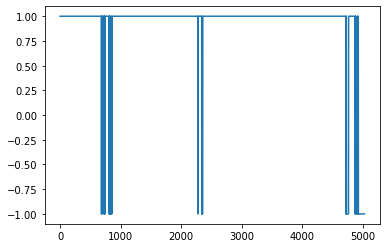

In [350]:
#plt.figure(figsize=(12,6))
plt.plot(p)

### Let's figure out how to plot it...


In [0]:
arry = p.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
#itemindex

<Figure size 1800x864 with 0 Axes>

Text(0.5, 1.0, 'IsolationForest - S&P 500')

[]

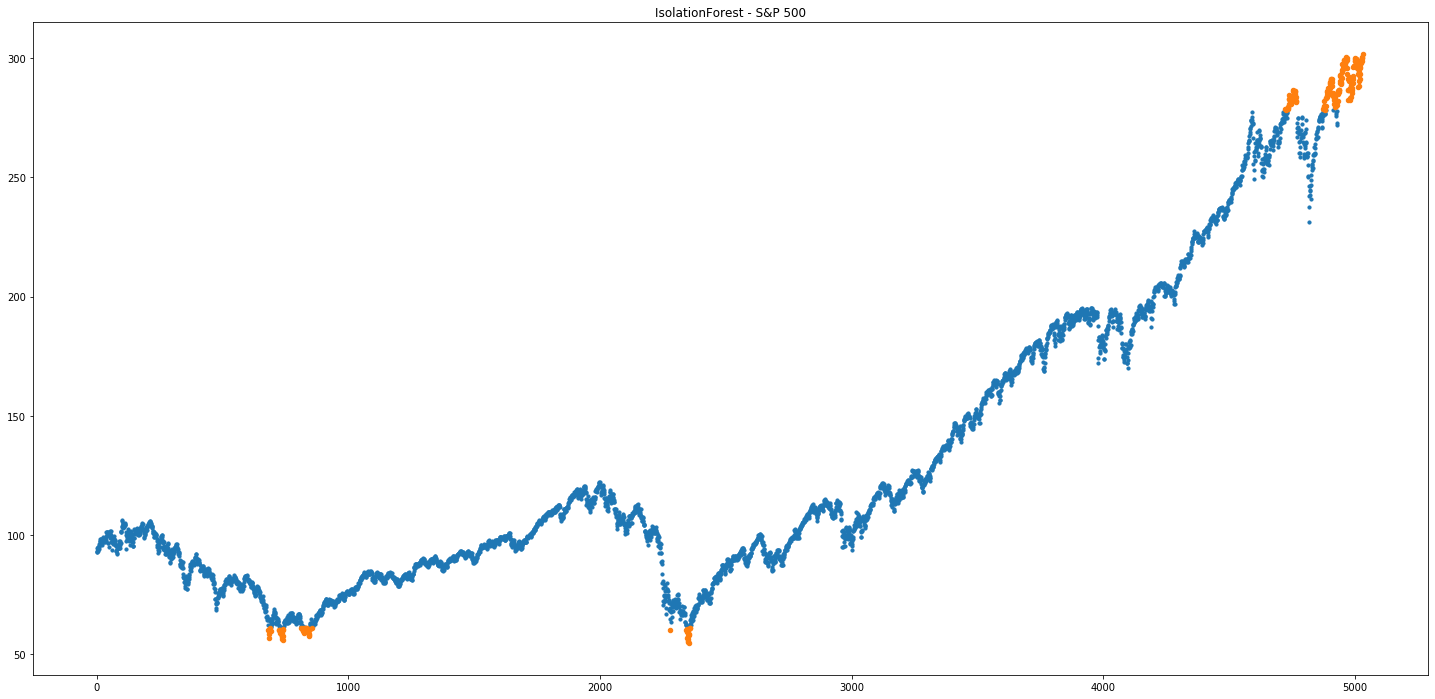

In [650]:
plt.figure(figsize=(25,12))
plt.title("IsolationForest - S&P 500")
x_axis = range(len(x))
out = plt.scatter(x_axis,y=x,s=10)
plt.scatter(itemindex,x[itemindex],s=20)
plt.plot()

In [645]:
anomalies = pd.DataFrame({
    'x' :list(itemindex)[0], 'y': x[itemindex]

})
anomalies
#anomalies.plot(x='x',y='y',figsize=(24,12), kind='scatter')

,x,y
0,682,60.27
1,683,58.49
2,684,56.89
3,685,60.28
4,686,59.77
...,...,...
247,5026,299.99
248,5027,299.01
249,5028,299.88
250,5029,300.37


## Lets try GaussianMixture 

In [487]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
pred = gmm.predict(X)
pred_prob = gmm.predict_proba(X)
scores= gmm.score_samples(X)
scoresMean = scores.mean()

In [0]:
#print(pred[:1000])

In [0]:
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry>0)


<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'GaussianMixture - S&P 500')

[]

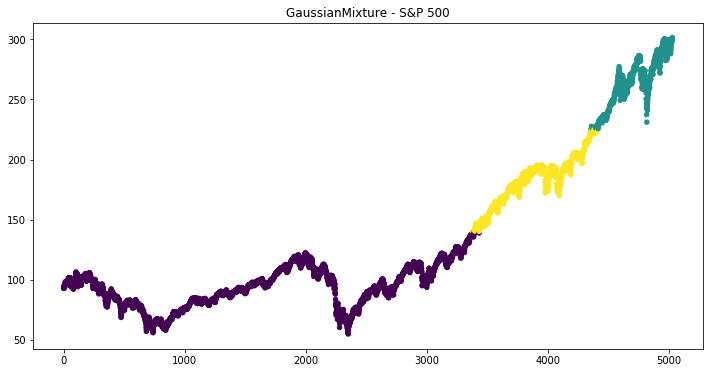

In [517]:
plt.figure(figsize=(12,6))
plt.title("GaussianMixture - S&P 500")
x_axis = range(len(x))
out = plt.scatter(x_axis,y=x,s=20,c=pred) # added c=pred
#plt.scatter(itemindex,x[itemindex],s=20,color='r') #

plt.plot()

Ive got no clue how/why this is considered as 'useful'... let's move on..

## OK lets try what EllipticEnvelope is  

In [534]:
SPY = yf.Ticker("spx")
SPY = SPY.history(period='20y')
SPY_open = pd.DataFrame({'close':SPY["Close"]})

x= spy.close.values # ndarray 
X = x.reshape(-1,1)


from sklearn.covariance import EllipticEnvelope
ev = EllipticEnvelope(contamination=.15)
ev.fit(X)

EllipticEnvelope(assume_centered=False, contamination=0.15, random_state=None,
                 store_precision=True, support_fraction=None)

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'EllipticEnvelope - S&P 500')

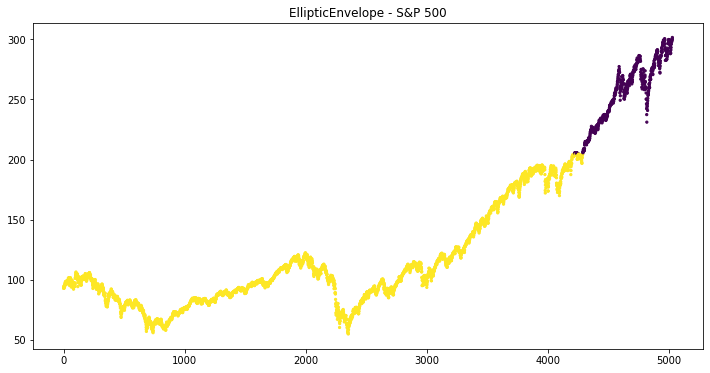

In [535]:
cluster = ev.predict(X)

plt.figure(figsize=(12,6))
plt.title("EllipticEnvelope - S&P 500")
plt.scatter(range(len(X)), X,s=5,c=cluster)

well thats also useless...

## Let's try OneClassSVM 

In [602]:
from sklearn.svm import OneClassSVM
svm = OneClassSVM(degree=5)
svm.fit(X)
pred = svm.predict(X)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=5, gamma='auto_deprecated',
            kernel='rbf', max_iter=-1, nu=0.5, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

In [603]:
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

len of arry:       5031
len of itemindex:  2989


<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'OneClassSVM - S&P 500')

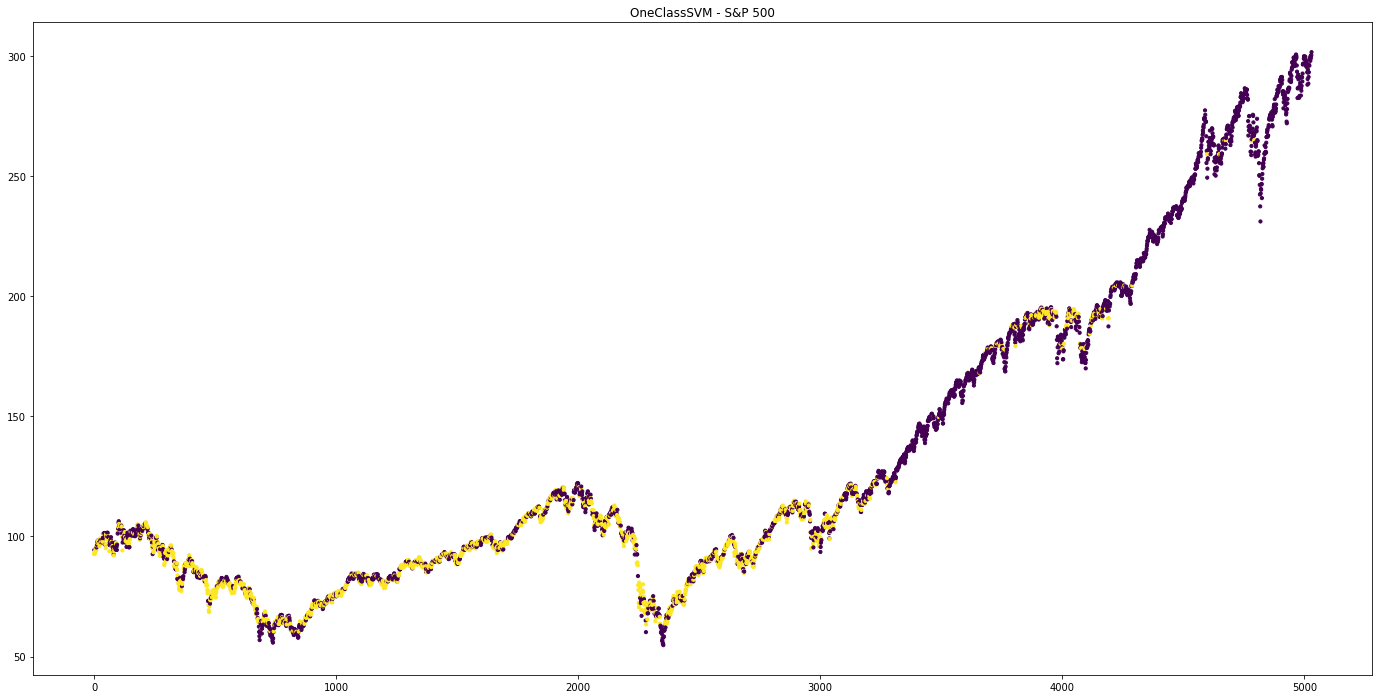

In [604]:
plt.figure(figsize=(24,12))
plt.title("OneClassSVM - S&P 500")
plt.scatter(range(len(X)), X,s=10,c=pred)

<Figure size 1728x864 with 0 Axes>

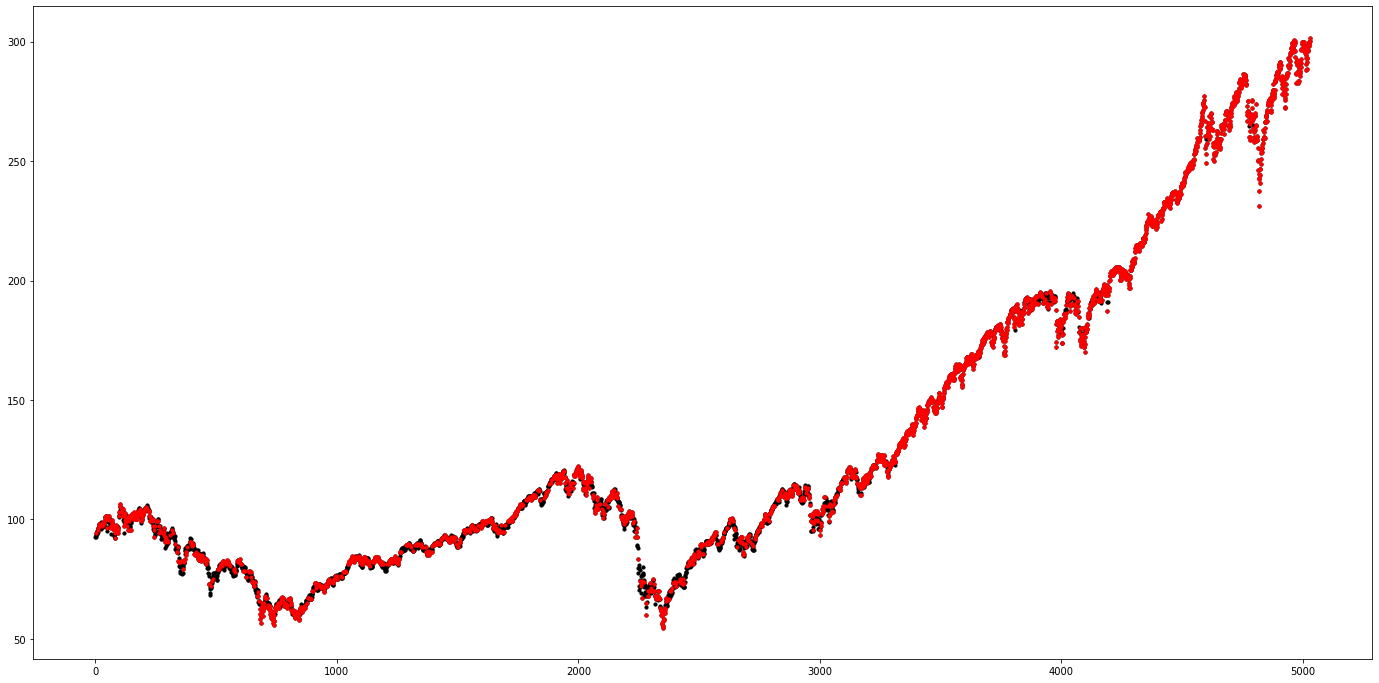

In [605]:
plt.figure(figsize=(24,12))
plt.title("OneClassSVM - S&P 500")
plt.scatter(range(len(X)), X,s=10,c='k')
plt.scatter(itemindex,x[itemindex],s=10,color='r') #

## Let's try LocalOutLierFactor 

In [653]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',leaf_size=40,contamination ='auto')#.05
pred = lof.fit_predict(X)

arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

array([ 1,  1,  1, ...,  1,  1, -1])

<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'LocalOutlierFactor - S&P 500')

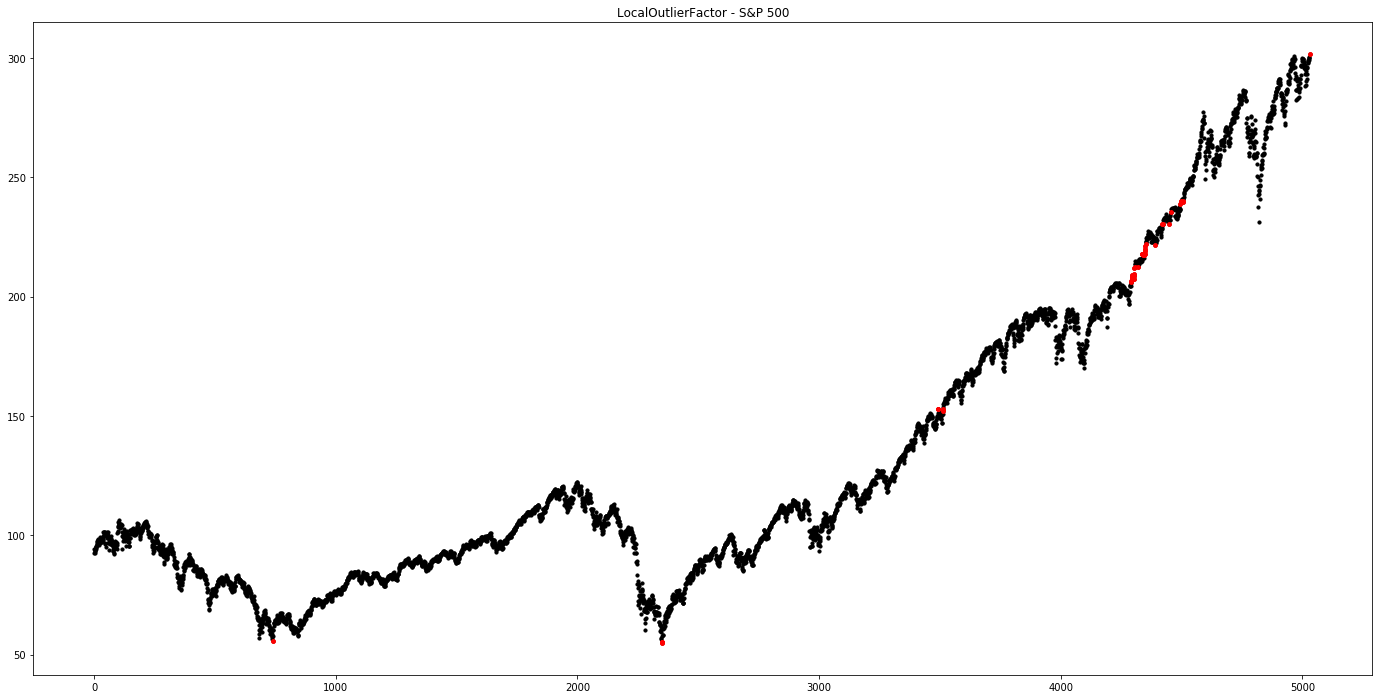

In [656]:
plt.figure(figsize=(24,12))
plt.title("LocalOutlierFactor - S&P 500")
plt.scatter(range(len(X)), X,s=10,c='k')
plt.scatter(itemindex,x[itemindex],s=15,color='r') #

len of arry:       5031
len of itemindex:  252


<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'LocalOutlierFactor - S&P 500')

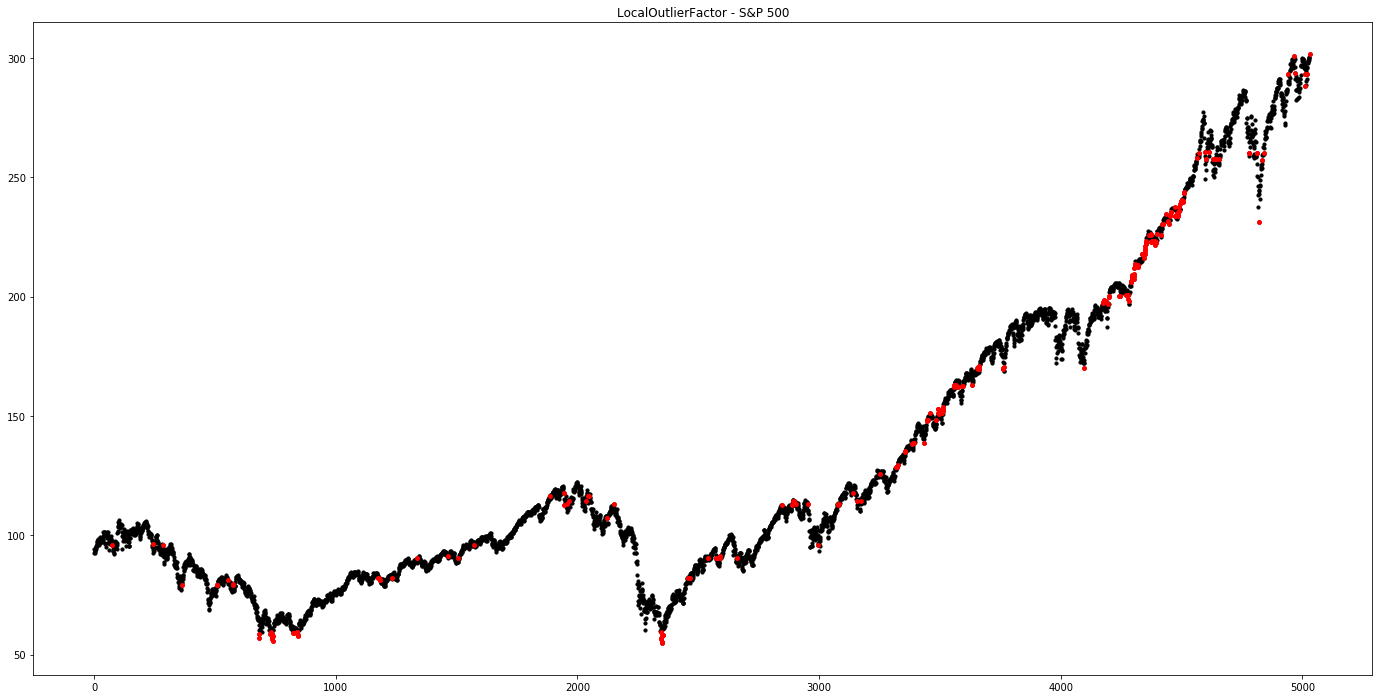

In [662]:
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto',leaf_size=40,contamination =.05)#.05
pred = lof.fit_predict(X)

arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

plt.figure(figsize=(24,12))
plt.title("LocalOutlierFactor - S&P 500")
plt.scatter(range(len(X)), X,s=10,c='k')
plt.scatter(itemindex,x[itemindex],s=15,color='r') #

# so IsolationForest, and LocalOutlierFactor are the best

## Let's try DBscan

 tune eps to get  < 3% in itemindex (number of anomalies) 

In [729]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=.45,leaf_size=500)

pred = dbscan.fit_predict(X)
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)

print('\nlen of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))
arry


len of arry:       5031
len of itemindex:  53


array([ 0,  0,  0, ..., 32, 32, -1])

**NOISY SAMPLES**

<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'DBSCAN NOISY SAMPLES - S&P 500')

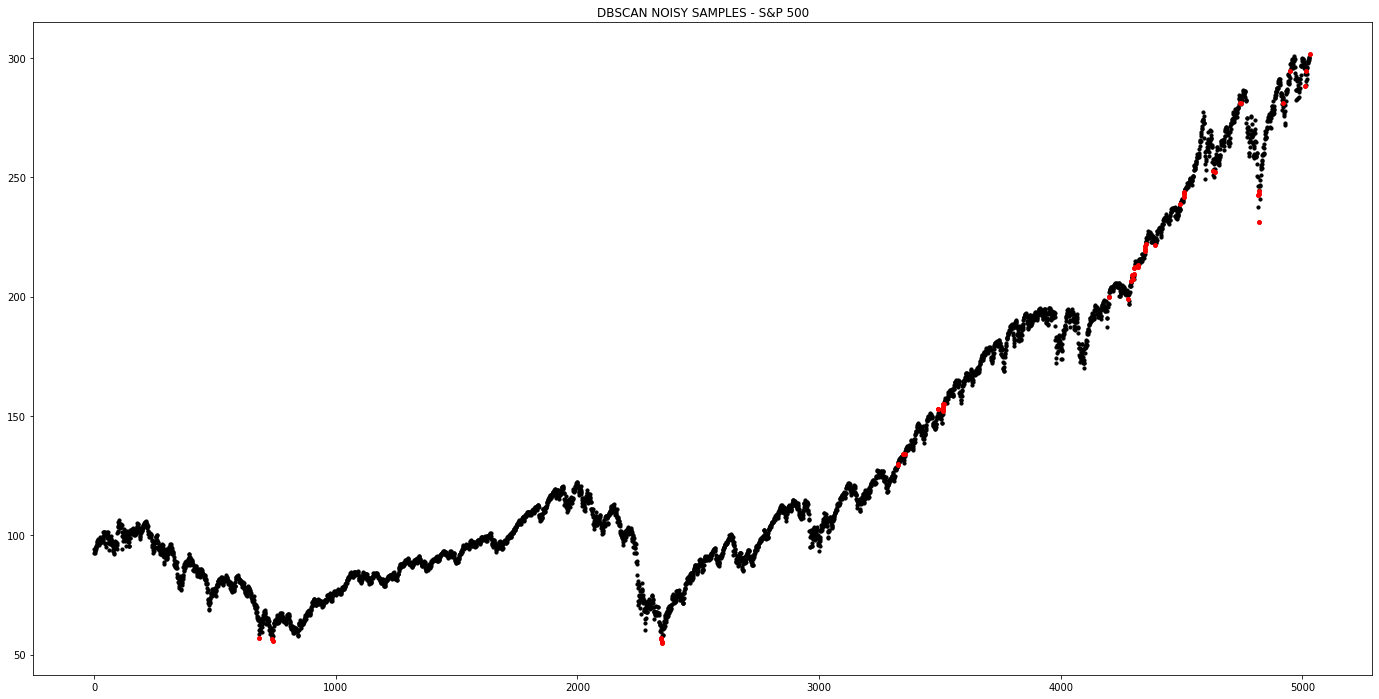

In [730]:
plt.figure(figsize=(24,12))
plt.title("DBSCAN NOISY SAMPLES - S&P 500")
plt.scatter(range(len(X)), X,s=10,c='k')
plt.scatter(itemindex,x[itemindex],s=15,color='r') #

Text(0.5, 1.0, 'DBSCAN - S&P 500')

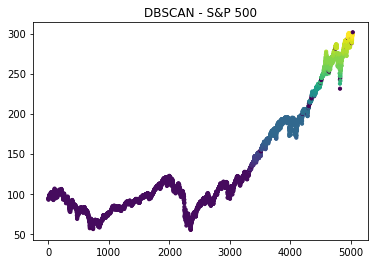

In [733]:
#plt.figure(figsize=(24,12))
plt.title("DBSCAN - S&P 500")
plt.scatter(range(len(X)), X,s=10,c=dbscan.labels_)

In [732]:
print(len(set(dbscan.labels_)), "fuckin clusters....")

34 fuckin clusters....


# let's try using pyod

In [810]:
import gc 
gc.collect()
# !pip install pyod

0

In [0]:
# from pyod.models.knn import KNN
# from pyod.models.iforest import IForest
# from pyod.models.lof import LOF
# from pyod.models.auto_encoder import AutoEncoder

# from pyod.models.abod import ABOD

# abod= ABOD(contamination=0.1)
# pred=abod.fit_predict(X)
# arry = pred.reshape(1,-1)[0]
# itemindex = np.where(arry==-1)

# print('\nlen of arry:      ',len(arry))
# print('len of itemindex: ',len(itemindex[0]))
# arry


# I didn't like that library; let's try another library